## 問題設定

下記の関数を最小化する
$$
\begin{equation}
    f(x,y,z) = xy -xz + 2yz + x - 2y + 3z 
\end{equation}
$$

$x,y,z$は1か0の値を取る二値変数とする

In [1]:
import numpy as np

from qiskit_optimization import QuadraticProgram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import QAOAAnsatz
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

## QUBOの定義

In [2]:
# QUBOの定義
qubo = QuadraticProgram("my-problem")

# 二値変数の設定
qubo.binary_var(f"x")
qubo.binary_var(f"y")
qubo.binary_var(f"z")

# コスト関数の設定
qubo.minimize(
    linear={"x":1, "y":-2, "z":3},
    quadratic={("x","y"):1, ("x","z"):-1, ("y","z"):2},
    constant=0
)
print(qubo.prettyprint())

# 二値変数から演算子への変換
cost_operator, offset = qubo.to_ising()

print("Pauli Operator")
print(cost_operator)

print("Offset value")
print(offset)

Problem name: my-problem

Minimize
  x*y - x*z + 2*y*z + x - 2*y + 3*z

Subject to
  No constraints

  Binary variables (3)
    x y z

Pauli Operator
SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[-0.5 +0.j,  0.25+0.j, -1.75+0.j,  0.25+0.j, -0.25+0.j,  0.5 +0.j])
Offset value
1.5


## 量子回路の作成

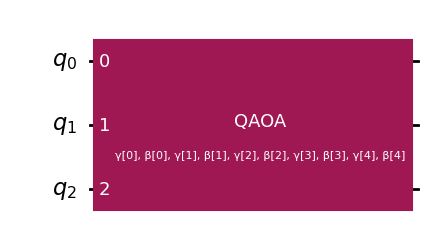

In [3]:
reps = 5
circuit = QAOAAnsatz(cost_operator=cost_operator, reps=reps) 
circuit.draw("mpl")

## コスト関数の作成

In [4]:
def cost_func(params):
    estimator = Estimator()
    pub = (circuit, cost_operator, params)
    job = estimator.run([pub])
    results = job.result()[0]
    energy = results.data.evs
    return energy 

## 最適化の実行

In [5]:
# パラメータ初期値
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta] * reps + [initial_gamma] * reps

In [6]:
# 最適化の実行
result = minimize(
    cost_func,
    init_params,
    method="COBYLA",
    tol=1e-3,
    )

print(result)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.924972219198015
       x: [ 2.991e+00  2.297e+00  1.838e+00  1.441e+00  1.179e+00
            3.085e+00  2.631e+00  3.838e+00  3.807e+00  3.035e+00]
    nfev: 1000
   maxcv: 0.0


##　解の評価

In [7]:
# 最適パラメータを割り当てる
optimized_circuit = circuit.assign_parameters(result.x)

### 状態ベクトルで確率分布を計算する

In [8]:
state = Statevector(optimized_circuit)

for key, value in state.probabilities_dict().items():
    print(f"str={key}, prob={value:.4f}")

str=000, prob=0.0079
str=001, prob=0.0867
str=010, prob=0.7813
str=011, prob=0.1074
str=100, prob=0.0123
str=101, prob=0.0015
str=110, prob=0.0020
str=111, prob=0.0009


### Samplerで確率分布をシミュレートする

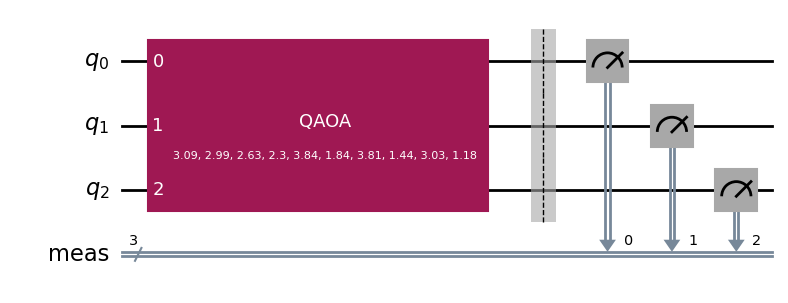

In [9]:
optimized_circuit_for_sampler =  optimized_circuit.copy()
optimized_circuit_for_sampler.measure_all()
optimized_circuit_for_sampler .draw("mpl", fold=False)

In [10]:
sampler = Sampler()
job = sampler.run([optimized_circuit_for_sampler], shots=1000)
result = job.result()

In [11]:
counts = result[0].data.meas.get_counts()
print(f"{counts=}")

shots = sum(counts.values())
print(f"{shots=}")

counts={'001': 88, '010': 777, '011': 114, '000': 7, '100': 12, '101': 2}
shots=1000


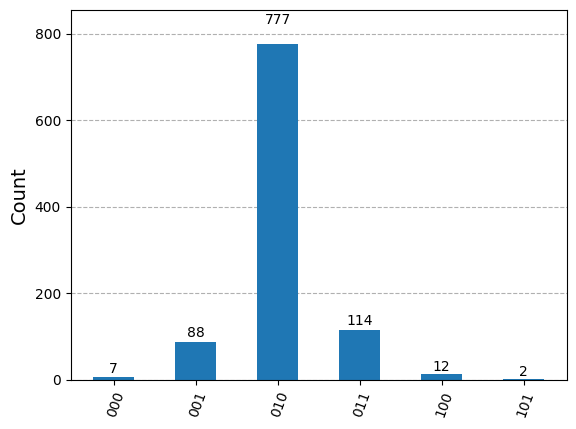

In [12]:
# 可視化
plot_histogram(counts)